# Angular correlation of bright object in LSST

In [1]:
import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus


import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
import lsst
import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle

#spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
#spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
#ang = spherePointCenter.separation(spt)
#ang_arcsec = ang.asArcseconds()

In [4]:
def calculateSeparation(ra0,dec0,ra,dec):
    spt0 = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    ang = spt0.separation(spt)
    ang_arcsec = ang.asArcseconds()
    return ang_arcsec
 

In [5]:
from lsst.geom import Angle 
import lsst
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_degToArcsec = lambda x : Angle(x,lsst.geom.degrees).asArcseconds()

In [6]:
df = pd.read_csv("list_of_isolatedobjects.csv",index_col=0)

In [7]:
df.head()

,idx_obj,ra,dec,magG,magR,magI,magZ,magY,smagG,smagR,smagI,smagZ,smagY,G_R,Z_Y,racosdec
0,60.0,122.458941,-36.203409,15.780089,15.296876,15.066548,14.977860,14.996176,0.017255,0.017876,0.018660,0.019977,0.017382,0.483214,-0.088688,98.815202
1,97.0,122.443234,-36.188544,16.447322,15.196784,14.543295,14.210779,14.027632,0.027123,0.020171,0.025437,0.018415,0.032334,1.250538,-0.332516,98.821288
2,101.0,122.476591,-36.168954,13.856892,13.132240,12.887973,12.778402,12.795855,0.023862,0.019996,0.022695,0.020973,0.033263,0.724652,-0.109571,98.872928
3,106.0,122.558799,-36.184124,14.714332,13.661116,13.156095,12.924743,12.855121,0.024281,0.020753,0.017012,0.022227,0.035247,1.053215,-0.231352,98.920140
4,114.0,122.556550,-36.138403,15.643555,15.108538,14.877074,14.796453,14.863543,0.021742,0.016813,0.019532,0.024336,0.048665,0.535016,-0.080621,98.976031


## Calculation of angle correlation

In [8]:
all_df = []
for index, row in df.iterrows():
    ra0 = row['ra']
    dec0 = row['dec']
    df1 = df.copy(deep=True)
    df1 = df1.iloc[index+1:] 
    df1["sep"]=df1.apply(lambda x : calculateSeparation(ra0,dec0,x['ra'],x['dec']),axis=1)
    all_df.append(df1)

## Separation angle distribution

In [9]:
all_sep = []
for df1 in all_df:
    if len(df1)>0:
        list_of_sep = df1["sep"].values
        all_sep.append(list_of_sep)
all_sep = np.concatenate(all_sep, axis=0)

In [10]:
image_size = 0.1*4000.

Text(0.5, 1.0, 'Bright source correlation ')

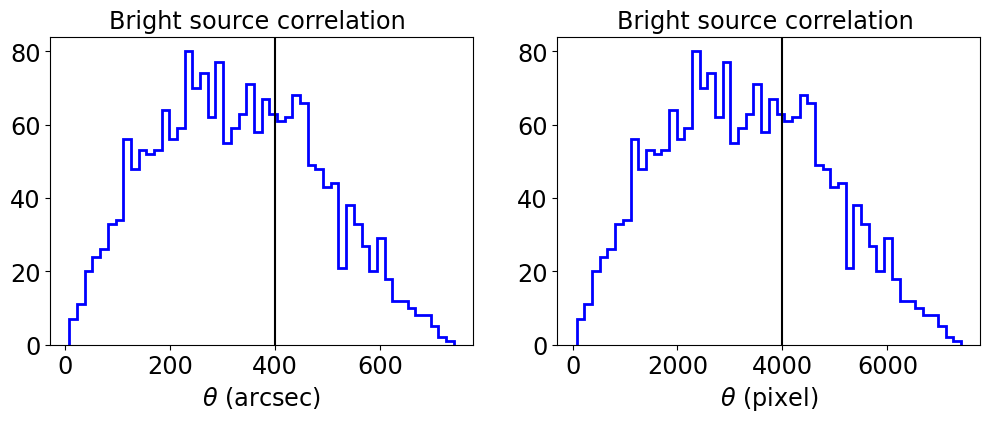

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax1,ax2=axs
ax1.hist(all_sep,bins=50,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title("Bright source correlation ")

all_sep_pix = all_sep/0.1
ax2.hist(all_sep_pix,bins=50,histtype="step",color="b",lw=2);
image_size = 4000.
ax2.axvline(image_size,color="k")
ax2.set_xlabel("$\\theta$ (pixel)")
ax2.set_title("Bright source correlation ")


In [15]:
all_pairs = []
for index, row in df.iterrows():
    idx0 = int(row["idx_obj"] )	
    ra0 = row['ra']
    dec0 = row['dec']
    df1 = all_df[index]
    for index1, row1 in df1.iterrows():
        idx1 = int(row1['idx_obj']) 	
        ra1 = row1['ra']
        dec1 = row1['dec']
        sep = row1['sep']
        all_pairs.append(np.array([idx0,idx1,sep]))
        
all_pairs = np.vstack(all_pairs)    

In [16]:
all_pairs 

array([[ 60.        ,  97.        ,  70.33006206],
       [ 60.        , 101.        , 134.22108483],
       [ 60.        , 106.        , 298.30782991],
       ...,
       [954.        , 966.        ,  54.4188175 ],
       [954.        , 972.        , 286.87791007],
       [966.        , 972.        , 340.55786532]])

In [18]:
df_pairs = pd.DataFrame(all_pairs, columns=["objidx1","objidx1","sep"] )

In [22]:
df_pairs.to_csv("all_pairs.csv")